# Requirements


In [1]:
 #!pip install datasets
 #!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu
!pip install 'torchmetrics[image]'

In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [5]:
# Root directory for dataset
root_dir="images/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [6]:
# Common image transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Create datasets for each folder
#dataset_inpainting = dset.ImageFolder(root=f"{root_dir}/inpainting", transform=transform)
#dataset_insight = dset.ImageFolder(root=f"{root_dir}/insight", transform=transform)
#dataset_text2img = dset.ImageFolder(root=f"{root_dir}/text2img", transform=transform)
dataset_wiki = dset.ImageFolder(root=f"{root_dir}/wiki", transform=transform)

# Assign labels: Real (1), Fake (0)
dataset_wiki.targets = torch.ones(len(dataset_wiki))  # Label 1
#dataset_insight.targets = torch.zeros(len(dataset_insight))  # Label 0
#dataset_text2img.targets = torch.zeros(len(dataset_text2img))  # Label 0
#dataset_inpainting.targets = torch.zeros(len(dataset_inpainting))  # Label 0
# Merge all datasets into one
#combined_dataset = ConcatDataset([dataset_inpainting, dataset_insight, dataset_text2img, dataset_wiki])

# Create the dataloader
dataloader = DataLoader(dataset_wiki, batch_size=128, shuffle=True, num_workers=2)

# Move data to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Weight Initialization

In [7]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

Generator

In [8]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# Discriminator

In [10]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


Loss Functions and Optimizers


In [12]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Computing Fréchet inception distance

In [13]:
import torch
import torchvision.transforms as transforms
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.models import inception_v3
from torchvision.utils import save_image

# Ensure FID calculation happens in evaluation mode
fid_metric = FrechetInceptionDistance(feature=2048).to("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
def compute_fid(real_images, fake_images, fid_metric):
    """Computes FID between real and fake images."""
    
    real_images = (real_images * 255).byte()
    fake_images = (fake_images * 255).byte()

    # Update the metric with real and fake images
    fid_metric.update(real_images, real=True)
    fid_metric.update(fake_images, real=False)

    # Compute FID
    fid_score = fid_metric.compute()
    
    # Reset metric for next evaluation
    fid_metric.reset()
    
    return fid_score.item()


Starting Training Loop...
[0/5][0/235] Loss_D: 1.7129 Loss_G: 2.8752 D(x): 0.3257 D(G(z)): 0.3004 / 0.0698
FID Score at Epoch 0: 465.6406


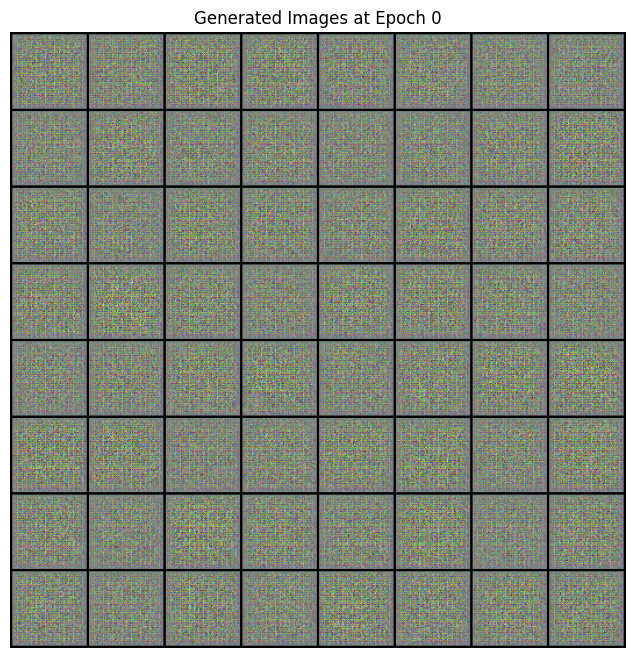

[0/5][50/235] Loss_D: 4.5204 Loss_G: 20.4087 D(x): 0.9823 D(G(z)): 0.9800 / 0.0000
[0/5][100/235] Loss_D: 0.5533 Loss_G: 3.9256 D(x): 0.7231 D(G(z)): 0.0871 / 0.0268
[0/5][150/235] Loss_D: 0.6368 Loss_G: 5.4546 D(x): 0.8621 D(G(z)): 0.3177 / 0.0062
[0/5][200/235] Loss_D: 0.3165 Loss_G: 6.9522 D(x): 0.9626 D(G(z)): 0.1668 / 0.0013
[1/5][0/235] Loss_D: 0.3260 Loss_G: 7.8987 D(x): 0.8513 D(G(z)): 0.0067 / 0.0007
[1/5][50/235] Loss_D: 0.7845 Loss_G: 5.7165 D(x): 0.8214 D(G(z)): 0.3415 / 0.0053
[1/5][100/235] Loss_D: 0.9026 Loss_G: 2.2892 D(x): 0.7398 D(G(z)): 0.3705 / 0.1299
[1/5][150/235] Loss_D: 0.6435 Loss_G: 3.2028 D(x): 0.7113 D(G(z)): 0.1866 / 0.0573
[1/5][200/235] Loss_D: 0.3825 Loss_G: 4.6241 D(x): 0.8349 D(G(z)): 0.0866 / 0.0164
[2/5][0/235] Loss_D: 0.3862 Loss_G: 6.9262 D(x): 0.9230 D(G(z)): 0.2443 / 0.0015


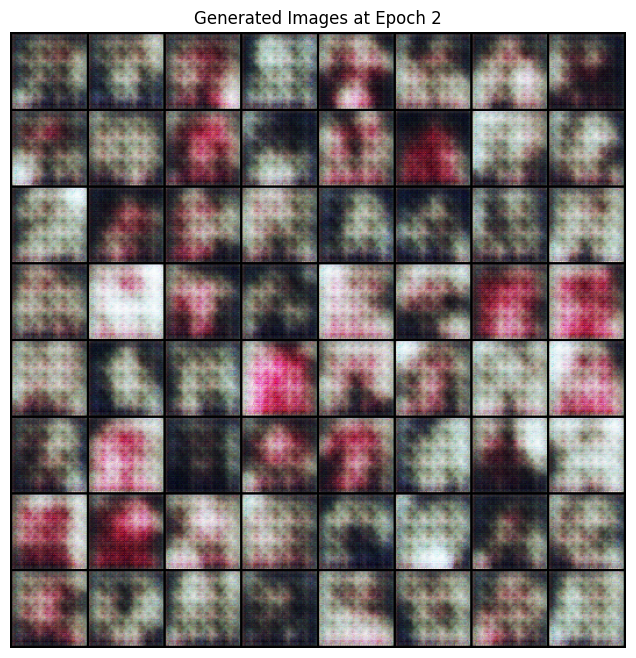

[2/5][50/235] Loss_D: 0.3300 Loss_G: 4.3363 D(x): 0.8541 D(G(z)): 0.1316 / 0.0196
[2/5][100/235] Loss_D: 0.3557 Loss_G: 2.7675 D(x): 0.8144 D(G(z)): 0.0916 / 0.0898
[2/5][150/235] Loss_D: 0.2868 Loss_G: 3.8528 D(x): 0.8253 D(G(z)): 0.0685 / 0.0309
[2/5][200/235] Loss_D: 0.3288 Loss_G: 3.7504 D(x): 0.8474 D(G(z)): 0.1219 / 0.0287
[3/5][0/235] Loss_D: 0.3131 Loss_G: 4.8104 D(x): 0.8941 D(G(z)): 0.1611 / 0.0109
[3/5][50/235] Loss_D: 0.3454 Loss_G: 4.6496 D(x): 0.8559 D(G(z)): 0.0888 / 0.0167
[3/5][100/235] Loss_D: 0.6470 Loss_G: 5.2312 D(x): 0.6076 D(G(z)): 0.0053 / 0.0159
[3/5][150/235] Loss_D: 0.4017 Loss_G: 4.8136 D(x): 0.7905 D(G(z)): 0.0837 / 0.0151
[3/5][200/235] Loss_D: 0.3734 Loss_G: 3.8001 D(x): 0.8401 D(G(z)): 0.0784 / 0.0304
[4/5][0/235] Loss_D: 0.4621 Loss_G: 5.8111 D(x): 0.8825 D(G(z)): 0.2485 / 0.0058
[4/5][50/235] Loss_D: 0.4621 Loss_G: 3.6690 D(x): 0.7601 D(G(z)): 0.0775 / 0.0412


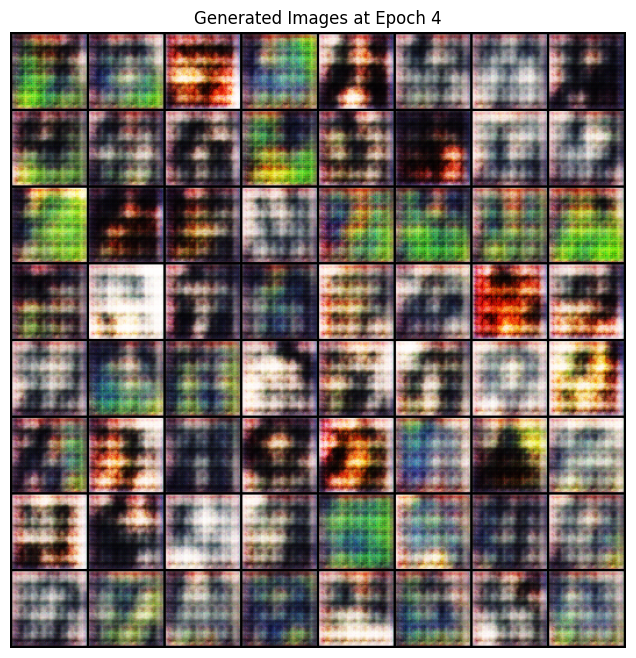

[4/5][100/235] Loss_D: 0.6839 Loss_G: 4.2872 D(x): 0.8246 D(G(z)): 0.2759 / 0.0239
[4/5][150/235] Loss_D: 0.6022 Loss_G: 2.8175 D(x): 0.7804 D(G(z)): 0.2389 / 0.0848
[4/5][200/235] Loss_D: 0.3057 Loss_G: 4.5117 D(x): 0.8986 D(G(z)): 0.1210 / 0.0165


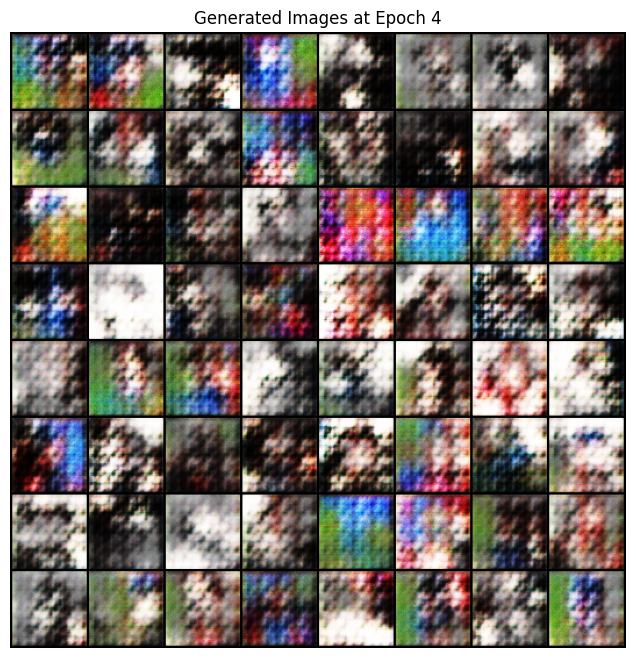

In [15]:
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
FID_scores = []
iters = 0
def show_generated_images(img_tensor, title=None):
    npimg = img_tensor.numpy()
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    if title:
        plt.title(title)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(dataloader, 0):  # Include dataset labels

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        # Move real images and labels to device
        real_cpu = images.to(device)
        labels = labels.to(device).float()  # Ensure labels are float
        labels = torch.clamp(labels, 0, 1)  # Clip values to ensure they are in range

        b_size = real_cpu.size(0)

        # Forward pass real and fake dataset images through D
        output = netD(real_cpu).view(-1)

        # Compute loss for real dataset images
        errD_real = criterion(output, labels)
        errD_real.backward()
        D_x = output.mean().item()

        ############################
        # Train with generated fake images
        ############################
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        fake_labels = torch.zeros(b_size, device=device, dtype=torch.float32)

        # Forward pass fake images through D
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, fake_labels)

        # Calculate gradients for fake images
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Compute total discriminator loss
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ############################
        netG.zero_grad()
        real_labels = torch.ones(b_size, device=device, dtype=torch.float32)

        # Forward pass fake images again
        output = netD(fake).view(-1)
        errG = criterion(output, real_labels)

        # Compute generator gradients
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Compute FID score every 5 epochs
        if epoch % 5 == 0 and i == 0:  # Compute FID at the start of an epoch
            with torch.no_grad():
                # Generate fake images
                noise = torch.randn(100, nz, 1, 1, device=device)  # 100 samples
                fake_images = netG(noise)

                # Get real images
                real_images, _ = next(iter(dataloader))
                real_images = real_images[:100].to(device)  # Use 100 real images

                # Compute FID
                fid_score = compute_fid(real_images, fake_images, fid_metric)
                fid_metric.reset()

                FID_scores.append(fid_score)
                print(f"FID Score at Epoch {epoch}: {fid_score:.4f}")

        # Save generator outputs
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_grid=vutils.make_grid(fake, padding=2, normalize=True)
            show_generated_images(img_grid, f"Generated Images at Epoch {epoch}")
            
        iters += 1


# Real Images vs Fake Images

IndexError: list index out of range

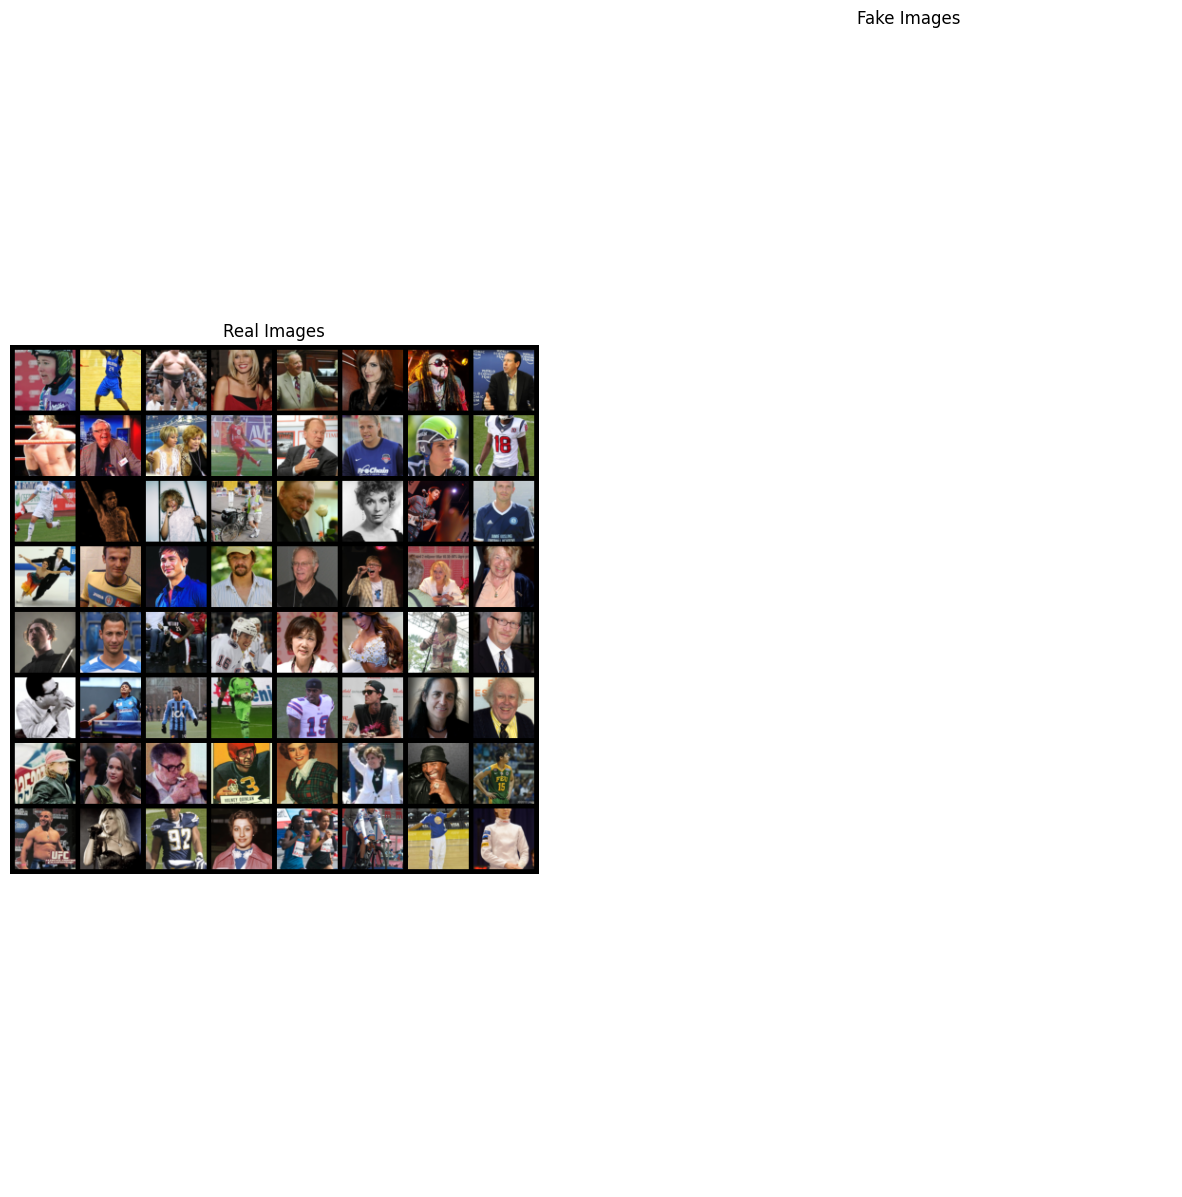

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()